In [62]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt

In [63]:
import matplotlib as mpl
import geopandas as gpd
import matplotlib.backends.backend_pdf

In [127]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [151]:
import matplotlib.patches as mpatches

## Generate maps of locations for which we have all data needed

In [ ]:
## load legal combos
import pickle
data_prep_dir = '/ihme/homes/beatrixh/notebooks/viv_rsc/data_prep/inputs/'

with open(data_prep_dir + 'lsff_vehicle_nutrient_pairs.pickle', 'rb') as handle:
    vehicle_nutrient_map = pickle.load(handle)
    
with open(data_prep_dir + 'lsff_country_vehicle_pairs.pickle', 'rb') as handle:
    country_vehicle_map = pickle.load(handle)
    
with open(data_prep_dir + 'lsff_vehicle_country_pairs.pickle', 'rb') as handle:
    vehicle_country_map = pickle.load(handle)

In [ ]:
## pull in shapefiles
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

world.name = world.name.astype(str)

world.loc[world.name=="Dem. Rep. Congo",'name'] = 'Democratic Republic of the Congo'
world.loc[world.name=="Tanzania",'name'] = 'United Republic of Tanzania'
world = world.rename(columns={'name':'location_name'})

In [2]:
## read in data
data_counts_full_path = '/ihme/homes/beatrixh/notebooks/viv_rsc/data_prep/outputs/data_counts_full.csv'
df = pd.read_csv(data_counts_full_path)

In [3]:
df.value_description = [i.replace(" ","_") for i in df.value_description]

In [4]:
df.head()

location_name      vehicle     nutrient  \
0        Angola  maize flour   folic acid   
1        Angola  maize flour         iron   
2        Angola  maize flour    vitamin a   
3        Angola  maize flour   vitamin b1   
4        Angola  maize flour  vitamin b12   

                                value_description  n_data_points  mean_mean  \
0  percent_of_market_covered_by_fortified_product              0        NaN   
1  percent_of_market_covered_by_fortified_product              0        NaN   
2  percent_of_market_covered_by_fortified_product              0        NaN   
3  percent_of_market_covered_by_fortified_product              0        NaN   
4  percent_of_market_covered_by_fortified_product              0        NaN   

  value_means  
0       [nan]  
1       [nan]  
2       [nan]  
3       [nan]  
4       [nan]

In [16]:
nutr_a = df[df.nutrient!='na']
nutr_na = df[df.nutrient=='na']

In [17]:
nutr_a = pd.pivot_table(nutr_a, index = ['location_name','vehicle','nutrient'], columns = 'value_description', values = 'mean_mean', dropna=False).reset_index()
nutr_na = pd.pivot_table(nutr_na, index = ['location_name','vehicle'], columns = 'value_description',values = 'mean_mean', dropna=False).reset_index()

In [203]:
compare_data = nutr_a.merge(nutr_na, on = ['location_name','vehicle'], how = 'outer')

In [204]:
compare_data.loc[(compare_data.percent_of_population_eating_vehicle.notna())&
            (compare_data.percent_of_population_eating_industrially_produced_vehicle.notna()) &
            (compare_data.percent_of_population_eating_fortified_vehicle.notna()),'tier'] = 1
compare_data.loc[(compare_data.percent_of_population_eating_vehicle.notna())&
            (compare_data.percent_of_vehicle_that_is_industrially_produced.notna()) &
            (compare_data.percent_of_vehicle_that_is_fortified.notna()) &
                 (compare_data.tier.isna()),'tier'] = 2

In [191]:
coverage_shp = world[['location_name','continent','geometry']].merge(compare_data, on = 'location_name', how = 'right')

In [21]:
# # these are the loc-vehicle-nutrient triplets with ideal data
# tier1 = compare_data[(compare_data.percent_of_population_eating_vehicle.notna())&
#             (compare_data.percent_of_population_eating_industrially_produced_vehicle.notna()) &
#             (compare_data.percent_of_population_eating_fortified_vehicle.notna())]

In [22]:
# # these are the loc-vehicle-nutrient triplets with tier_2 data
# tier2 = compare_data[(compare_data.percent_of_population_eating_vehicle.notna())&
#             (compare_data.percent_of_vehicle_that_is_industrially_produced.notna()) &
#             (compare_data.percent_of_vehicle_that_is_fortified.notna())]

In [23]:
# tier1 = set(zip(tier1.location_name,tier1.vehicle,tier1.nutrient))
# tier2 = set(zip(tier2.location_name,tier2.vehicle,tier2.nutrient))

In [211]:
compare_data_nutrient_na = compare_data.groupby(['location_name','vehicle']).mean().reset_index()

compare_data_nutrient_na.loc[(compare_data_nutrient_na.percent_of_population_eating_vehicle.notna())&
            (compare_data_nutrient_na.percent_of_population_eating_industrially_produced_vehicle.notna()) &
            (compare_data_nutrient_na.percent_of_population_eating_fortified_vehicle.notna()),'tier'] = 1

compare_data_nutrient_na.loc[(compare_data_nutrient_na.percent_of_population_eating_vehicle.notna())&
            (compare_data_nutrient_na.percent_of_vehicle_that_is_industrially_produced.notna()) &
            (compare_data_nutrient_na.percent_of_vehicle_that_is_fortified.notna()) &
                 (compare_data_nutrient_na.tier.isna()),'tier'] = 2

coverage_nutrient_na_shp = world[['location_name','continent','geometry']].merge(compare_data_nutrient_na, on = 'location_name', how = 'right')

In [195]:
def gen_plot_nutrient_specific(vehicle, nutrient):  
    
    # pull relevant countries
    target_countries = vehicle_country_map[vehicle]
    
    # initialize plot
    fig, ax = plt.subplots(figsize=(20,10))
    ax.set_aspect('equal')
    title_label = f'{vehicle.capitalize()} fortified with {nutrient}: data coverage'
    ax.set_title(title_label, fontsize = 24)
    ax.set_axis_off()

    # all country outlines
    base = world[world.continent.isin(['Africa','Asia'])].plot(ax=ax, color='white', edgecolor='gray')

    color_scale = cm.get_cmap('Blues')(np.linspace(1,0.3,2))
    
    color_dict = {'tier1':tuple(color_scale)[0],
                 'tier2':tuple(color_scale)[1],
                 'no_data':'gray'}

    label_dict = {'tier1':'Have all data',
                 'tier2':'Can calculate all data',
                 'no_data':'Missing data'}
        
        
    coverage_shp[(coverage_shp.vehicle==vehicle) &
         (coverage_shp.nutrient==nutrient) &
         (coverage_shp.tier==1)].plot(ax=base,
                              color = color_dict['tier1'],
                              label = 'have_data')
    
    coverage_shp[(coverage_shp.vehicle==vehicle) &
         (coverage_shp.nutrient==nutrient) &
         (coverage_shp.tier==2)].plot(ax=base,
                              color = color_dict['tier2'],
                              label = 'have_data')

    coverage_shp[(coverage_shp.vehicle==vehicle) &
         (coverage_shp.nutrient==nutrient) &
         (coverage_shp.location_name.isin(target_countries)) & 
         (coverage_shp.tier.isna())].plot(ax=base, color = color_dict['no_data'])
    
    LegendElement = [
        mpatches.Patch(facecolor = color_dict['tier1'], label = label_dict['tier1']),
        mpatches.Patch(facecolor = color_dict['tier2'], label = label_dict['tier2']),
        mpatches.Patch(facecolor = color_dict['no_data'], label = label_dict['no_data']),
        mpatches.Patch(facecolor = 'white', edgecolor='gray', label = 'Not modeled'),
    ]
    
    ax.legend(handles = LegendElement, fontsize = 18, loc = 4)
    
    return fig

/share/code/beatrixh/miniconda/envs/gis/lib/python3.6/site-packages/geopandas/plotting.py:532: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/share/code/beatrixh/miniconda/envs/gis/lib/python3.6/site-packages/geopandas/plotting.py:532: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/share/code/beatrixh/miniconda/envs/gis/lib/python3.6/site-packages/geopandas/plotting.py:532: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/share/code/beatrixh/miniconda/envs/gis/lib/python3.6/site-packages/geopandas/plotting.py:532: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/share/code/beatrixh/miniconda/envs/gis/lib/python3.6/site-packages/geopandas/plotting.py:532: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been d

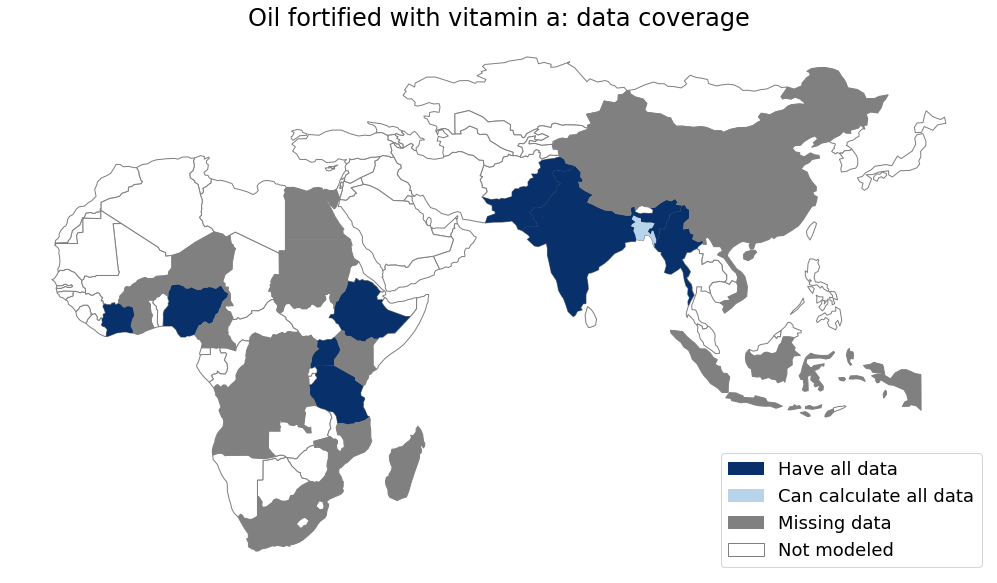

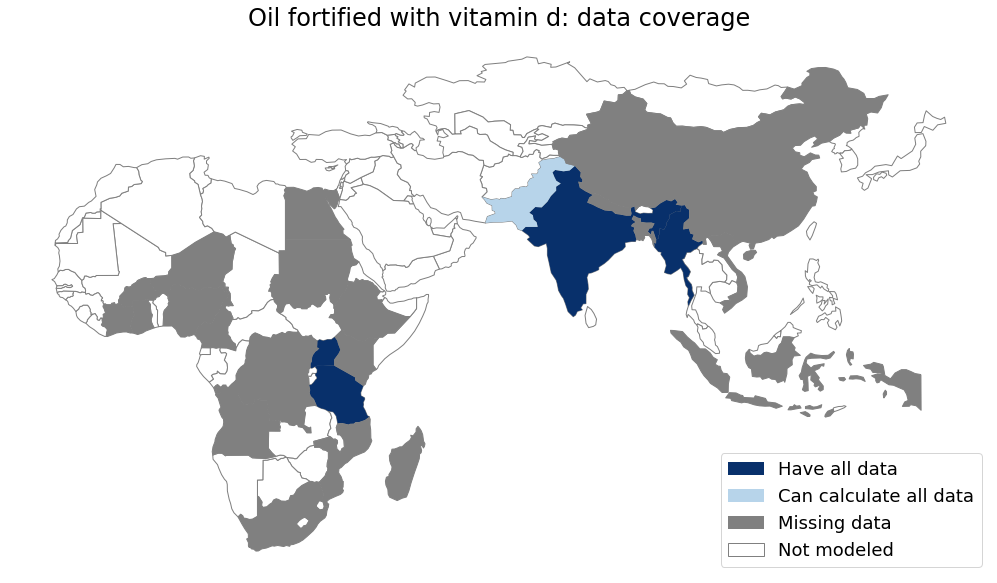

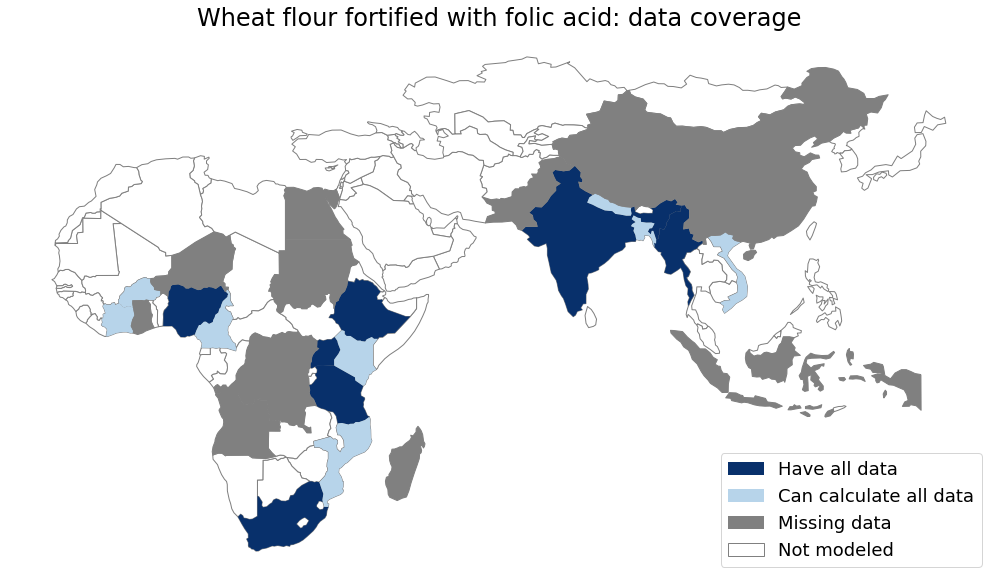

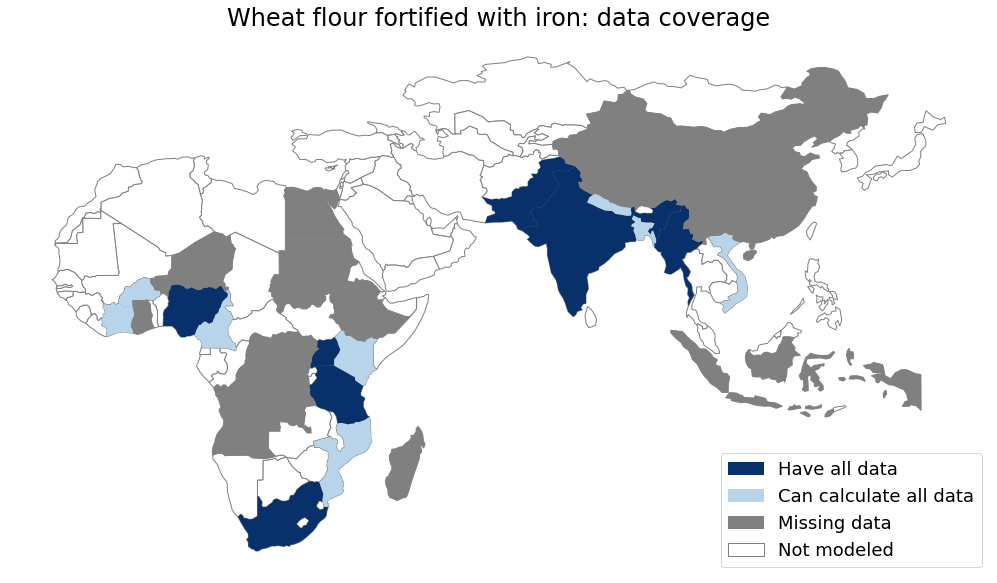

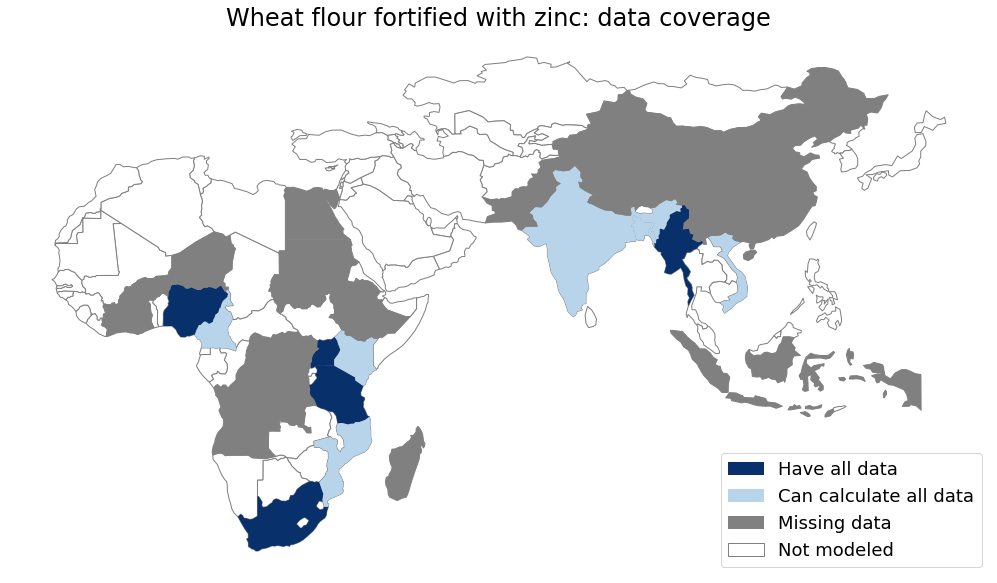

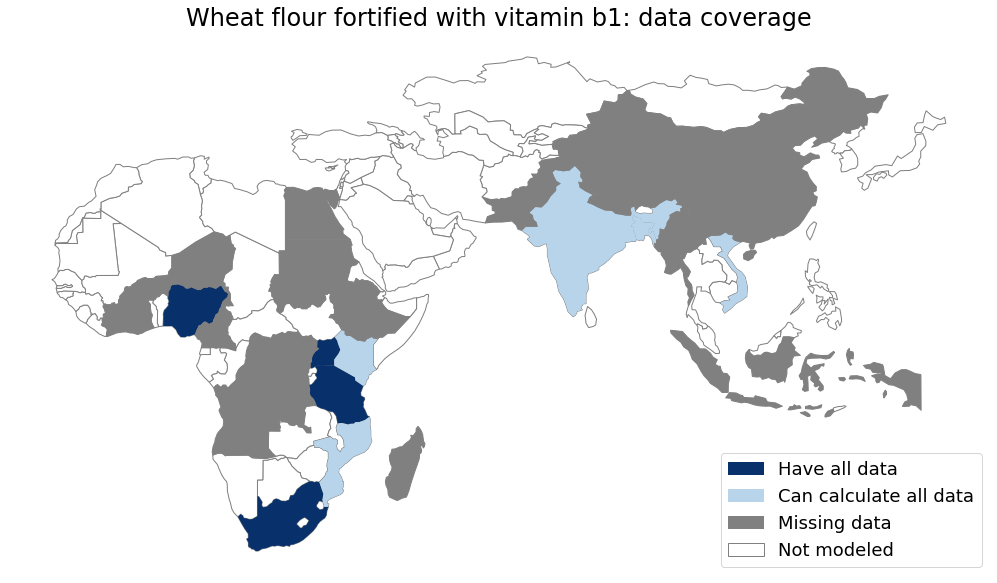

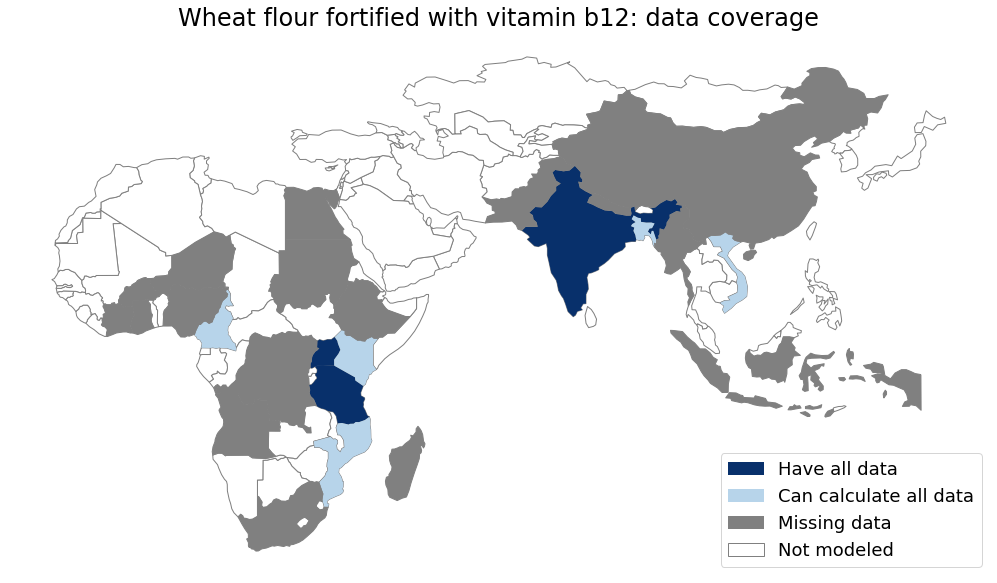

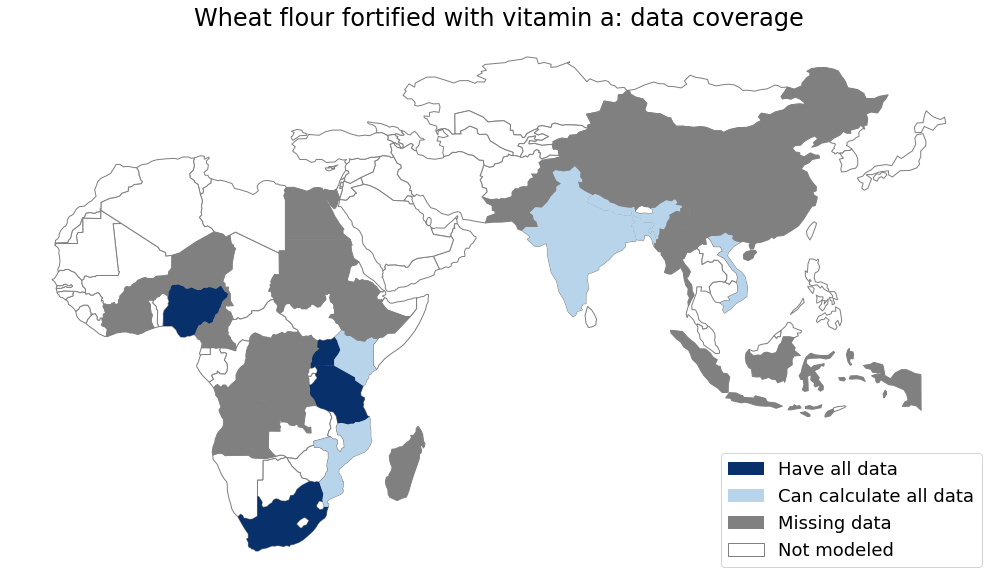

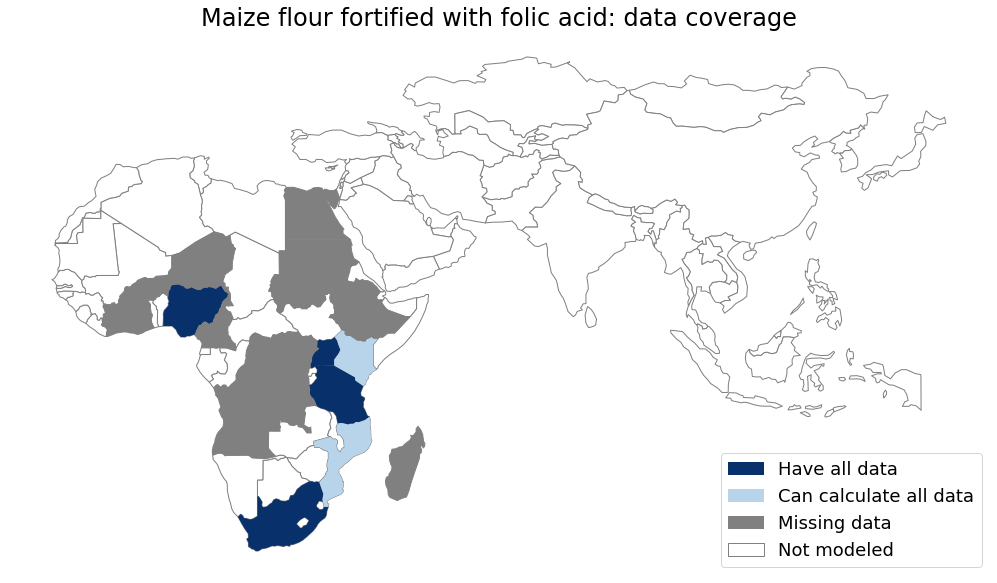

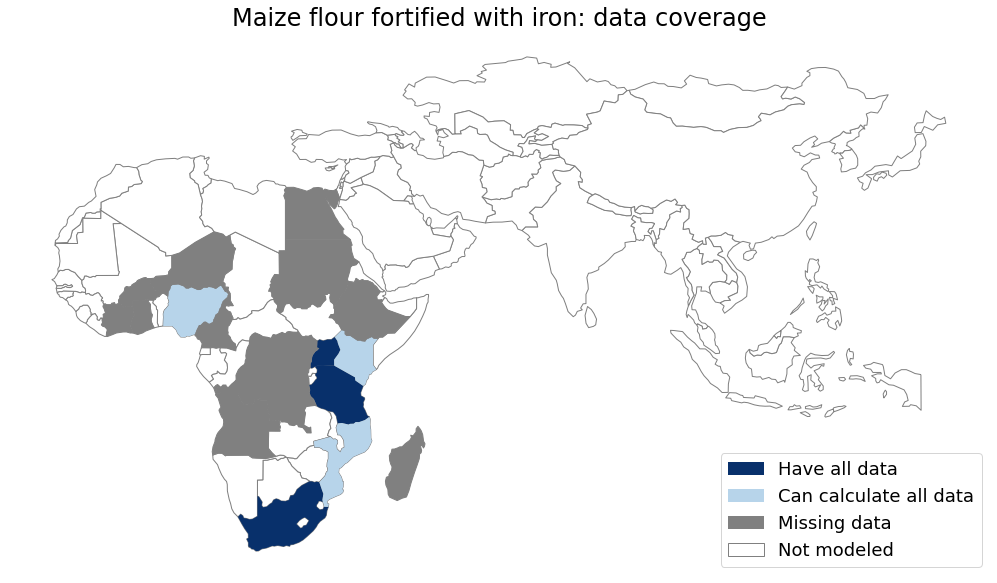

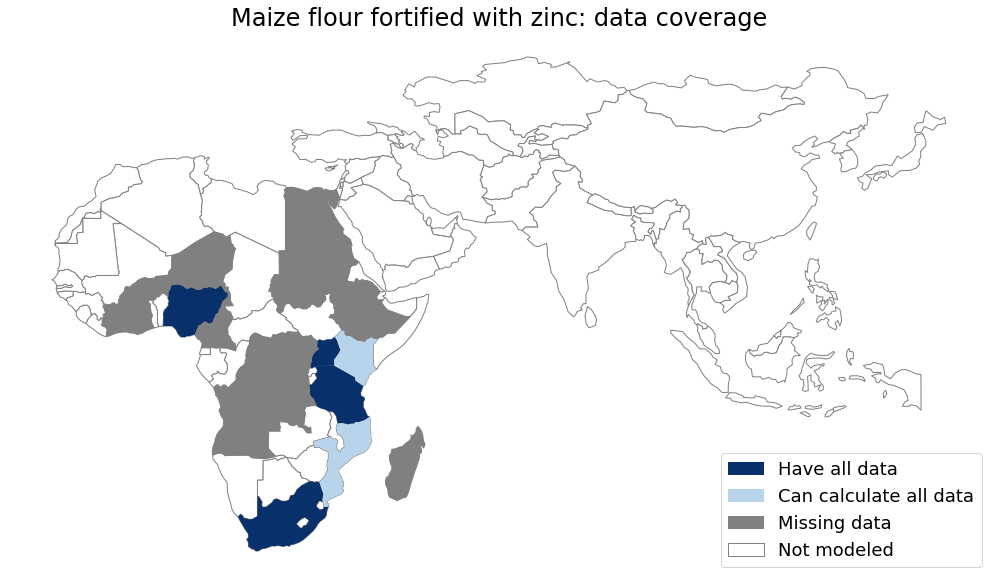

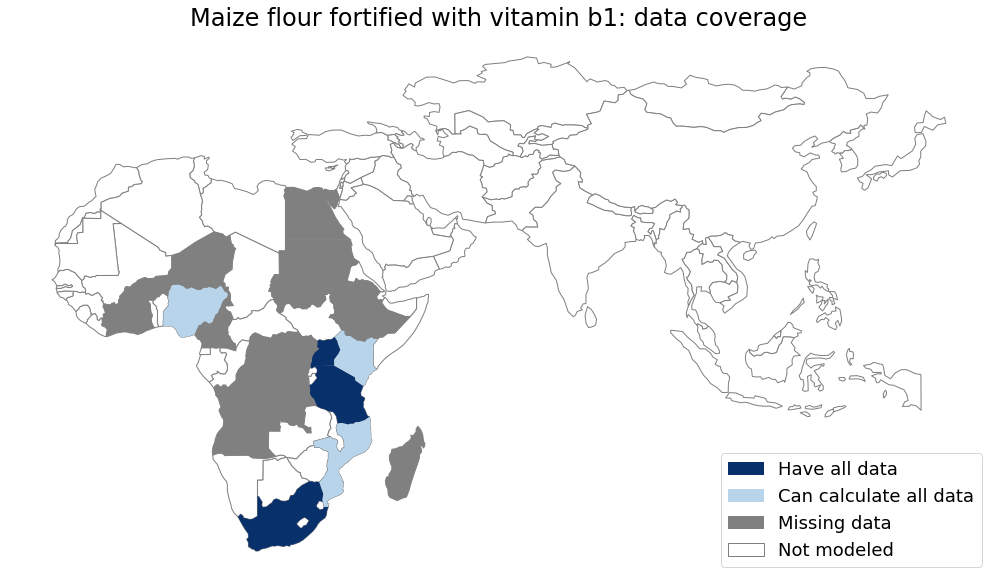

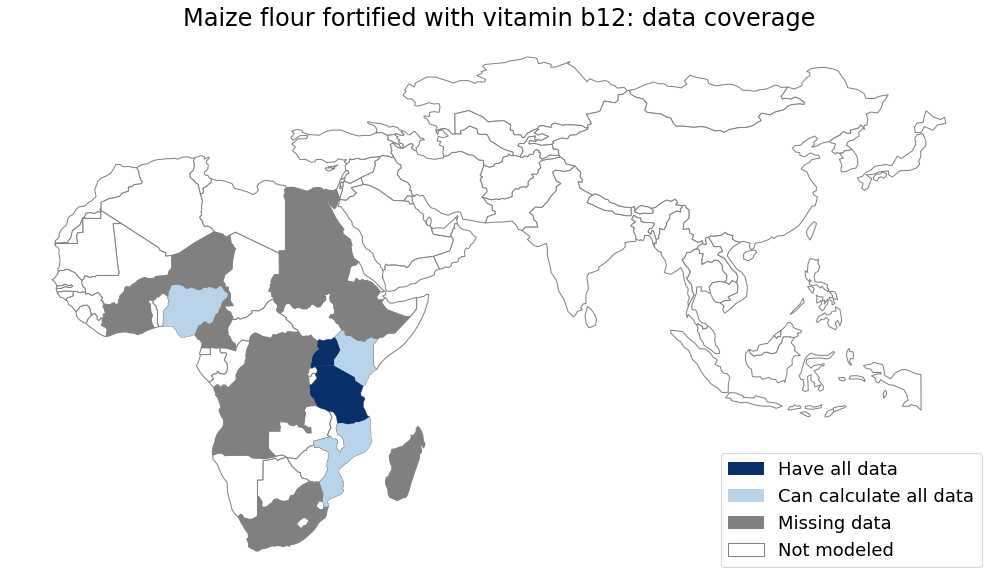

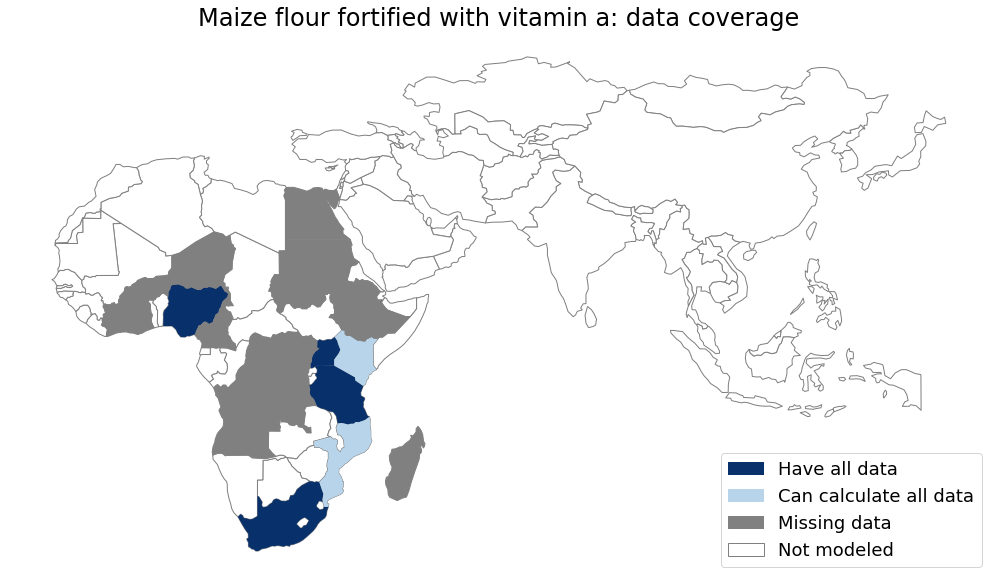

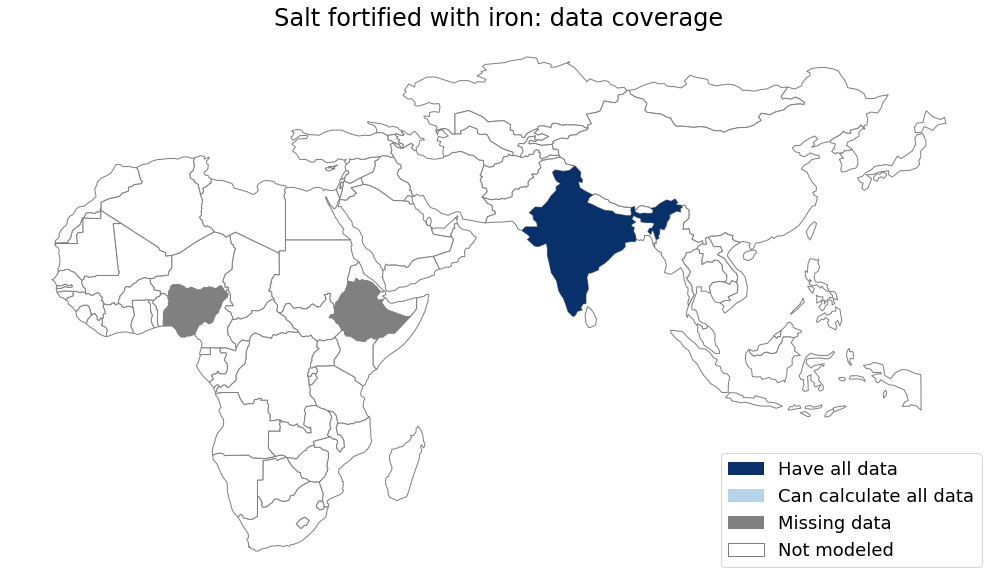

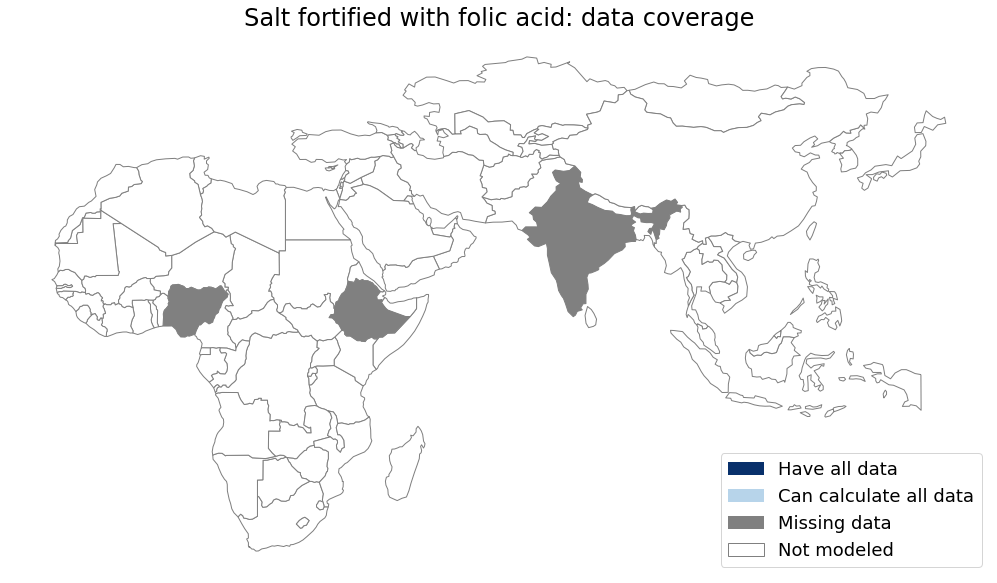

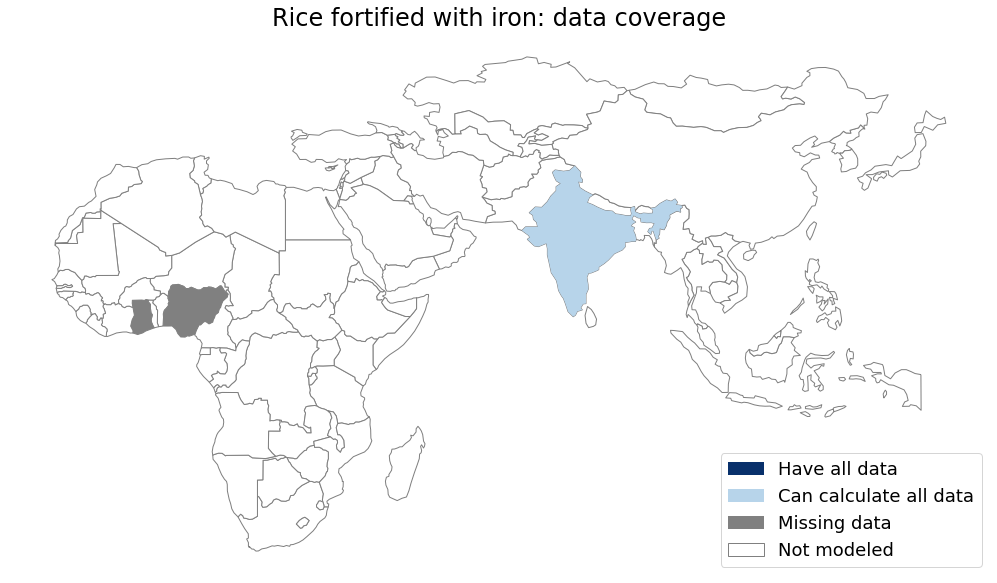

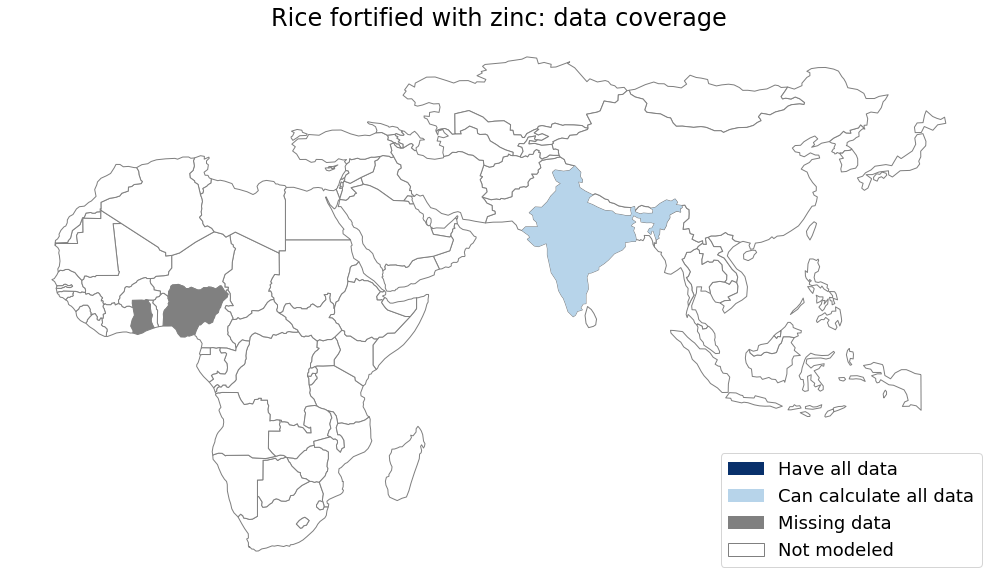

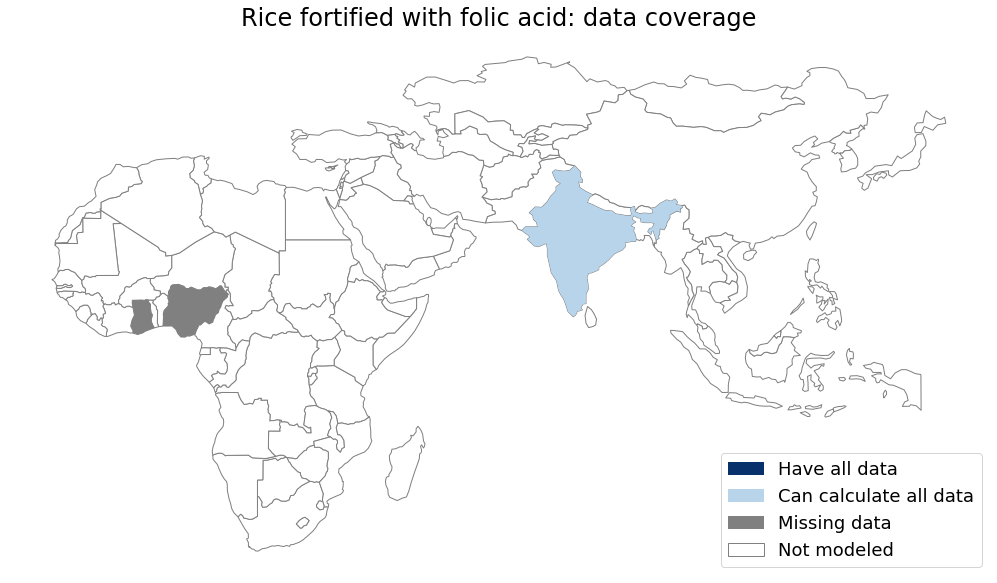

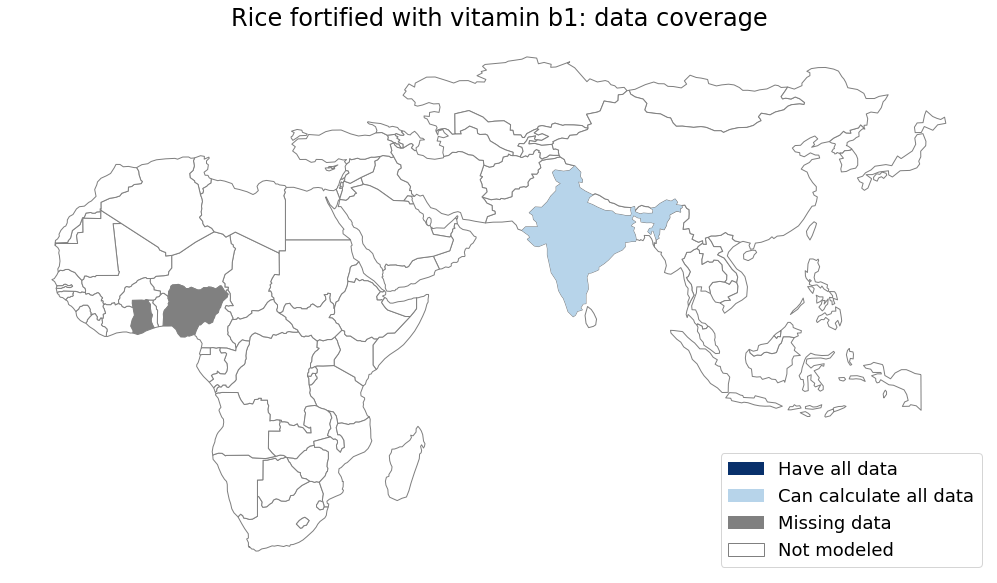

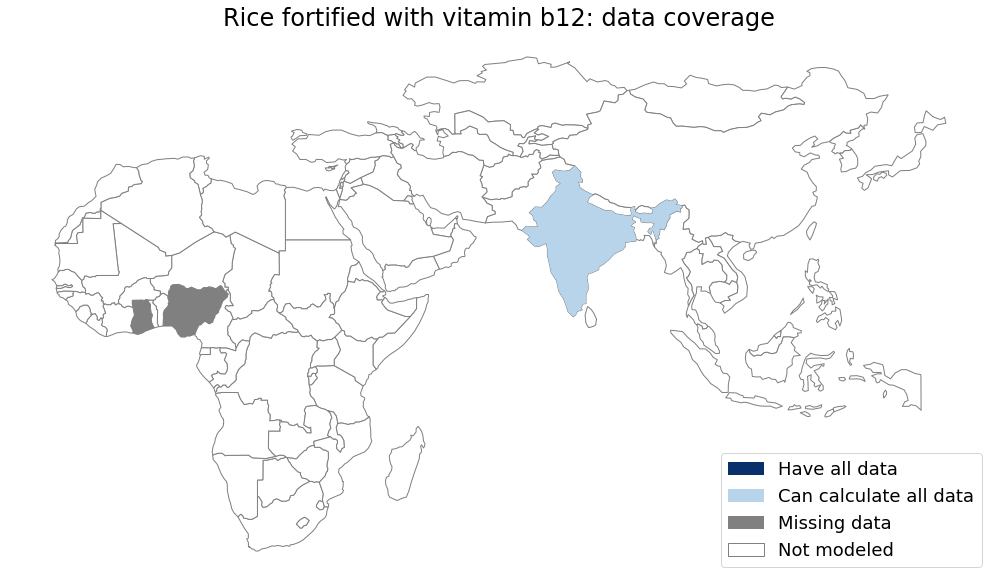

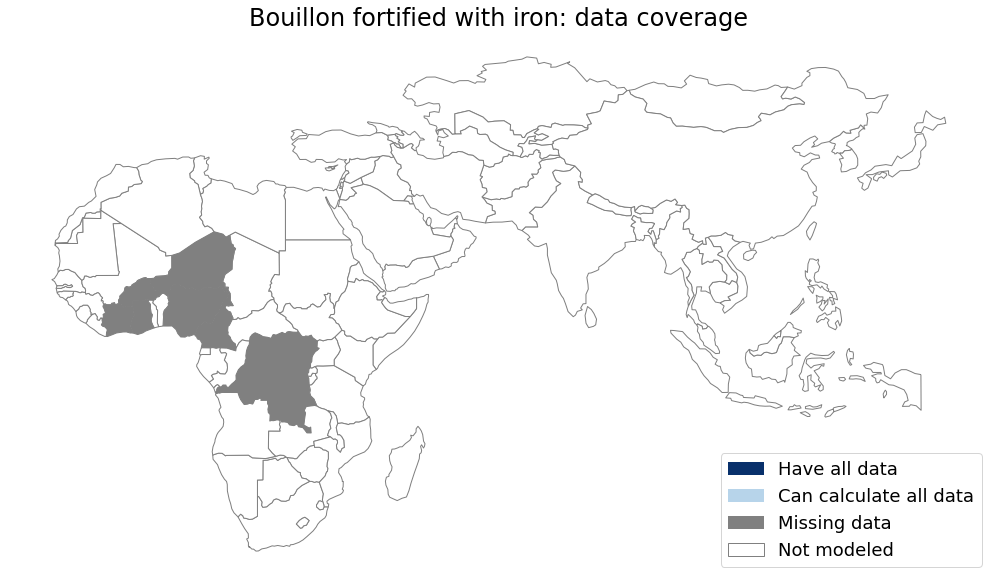

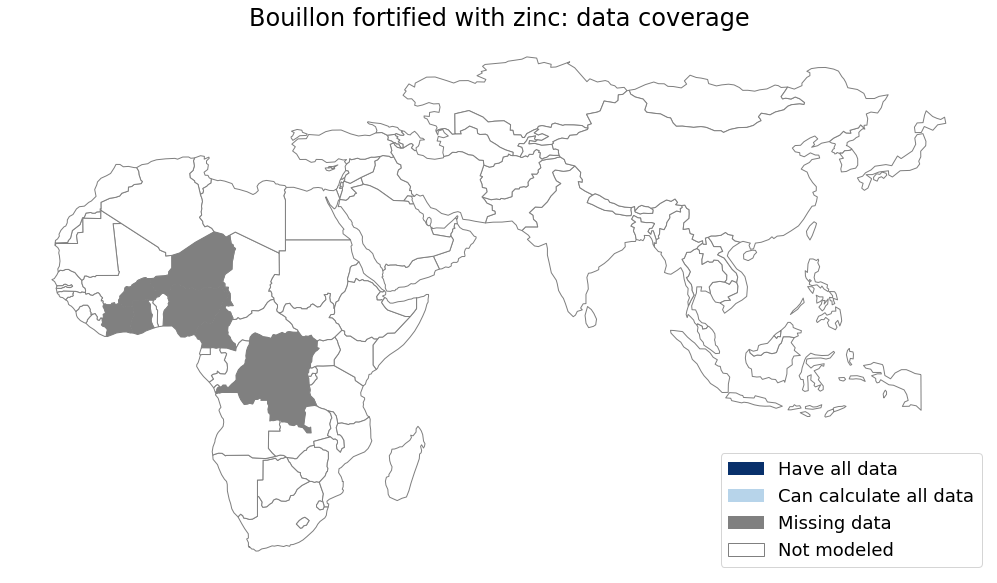

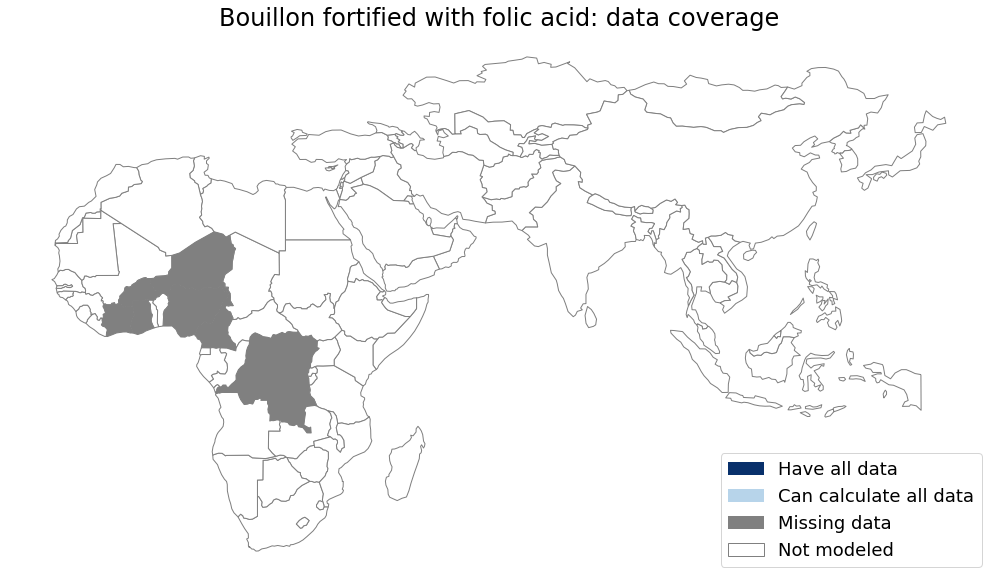

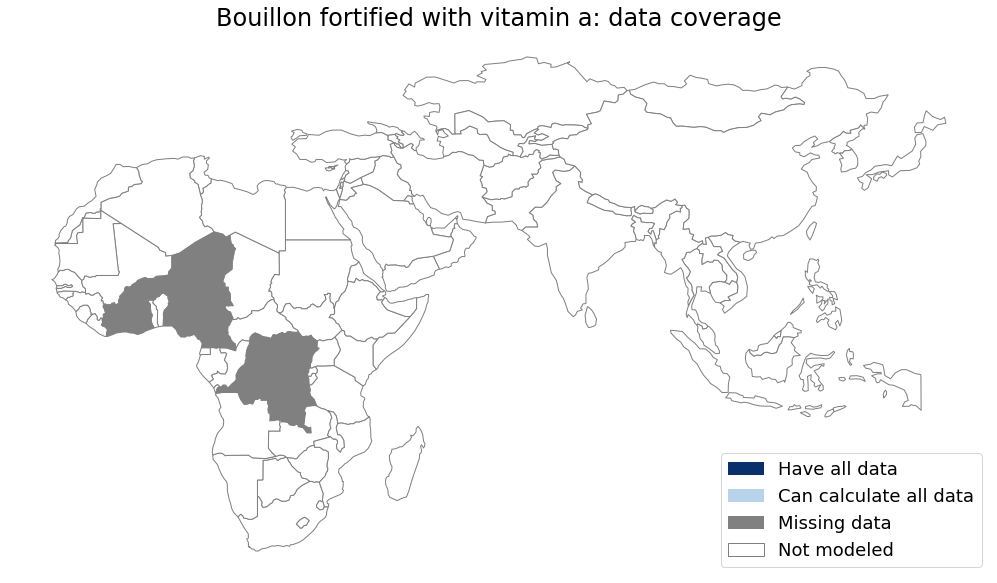

In [198]:
for vehicle in vehicle_country_map.keys():
    vehicle_name = vehicle.replace(" ","_")
    save_path = f'/ihme/homes/beatrixh/notebooks/viv_rsc/data_prep/outputs/plots/viv_model_input_data_coverage/data_completeness_{vehicle_name}.pdf'
    pdf = matplotlib.backends.backend_pdf.PdfPages(save_path)
    for nutrient in vehicle_nutrient_map[vehicle]:
        fig = gen_plot_nutrient_specific(vehicle, nutrient)
        pdf.savefig(fig)
    pdf.close()

In [214]:
def gen_plot_nutrient_agnostic(vehicle):  
    
    # pull relevant countries
    target_countries = vehicle_country_map[vehicle]
    
    # initialize plot
    fig, ax = plt.subplots(figsize=(20,10))
    ax.set_aspect('equal')
    title_label = f'{vehicle.capitalize()}: data coverage'
    ax.set_title(title_label, fontsize = 24)
    ax.set_axis_off()

    # all country outlines
    base = world[world.continent.isin(['Africa','Asia'])].plot(ax=ax, color='white', edgecolor='gray')

    color_scale = cm.get_cmap('Blues')(np.linspace(1,0.3,2))
    
    color_dict = {'tier1':tuple(color_scale)[0],
                 'tier2':tuple(color_scale)[1],
                 'no_data':'gray'}

    label_dict = {'tier1':'Have all data',
                 'tier2':'Can calculate all data',
                 'no_data':'Missing data'}
        
        
    coverage_nutrient_na_shp[(coverage_nutrient_na_shp.vehicle==vehicle) &
         (coverage_nutrient_na_shp.tier==1)].plot(ax=base,
                              color = color_dict['tier1'],
                              label = 'have_data')
    
    coverage_nutrient_na_shp[(coverage_nutrient_na_shp.vehicle==vehicle) &
         (coverage_nutrient_na_shp.tier==2)].plot(ax=base,
                              color = color_dict['tier2'],
                              label = 'have_data')

    coverage_nutrient_na_shp[(coverage_nutrient_na_shp.vehicle==vehicle) &
         (coverage_nutrient_na_shp.location_name.isin(target_countries)) & 
         (coverage_nutrient_na_shp.tier.isna())].plot(ax=base, color = color_dict['no_data'])
    
    LegendElement = [
        mpatches.Patch(facecolor = color_dict['tier1'], label = label_dict['tier1']),
        mpatches.Patch(facecolor = color_dict['tier2'], label = label_dict['tier2']),
        mpatches.Patch(facecolor = color_dict['no_data'], label = label_dict['no_data']),
        mpatches.Patch(facecolor = 'white', edgecolor='gray', label = 'Not modeled'),
    ]
    
    ax.legend(handles = LegendElement, fontsize = 18, loc = 4)
    
    return fig

/share/code/beatrixh/miniconda/envs/gis/lib/python3.6/site-packages/geopandas/plotting.py:532: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/share/code/beatrixh/miniconda/envs/gis/lib/python3.6/site-packages/geopandas/plotting.py:532: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/share/code/beatrixh/miniconda/envs/gis/lib/python3.6/site-packages/geopandas/plotting.py:532: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


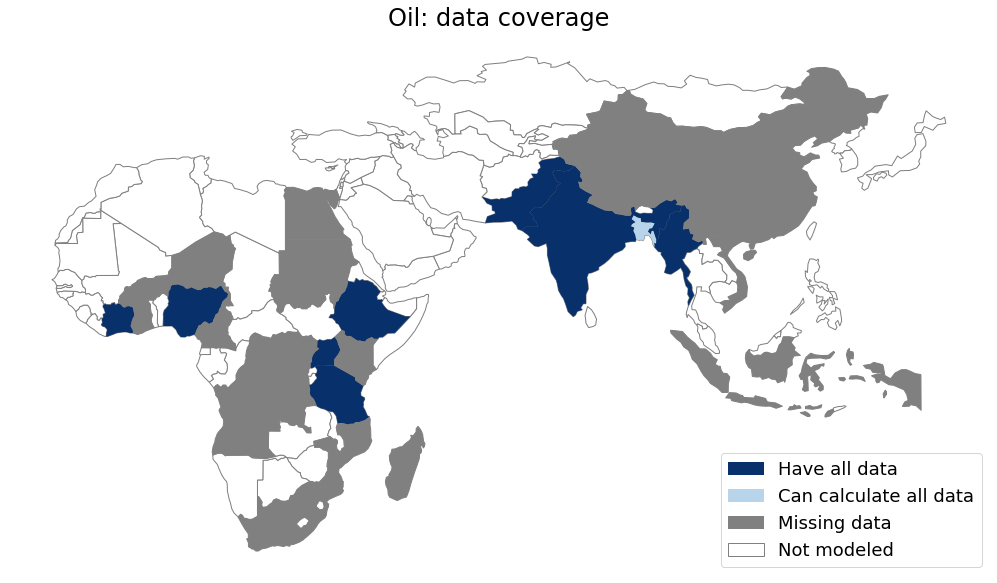

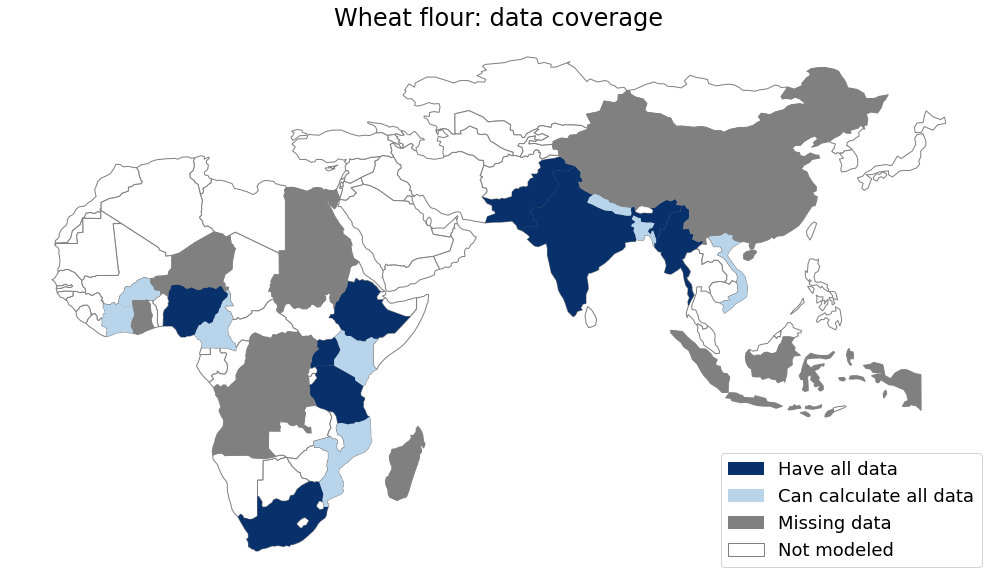

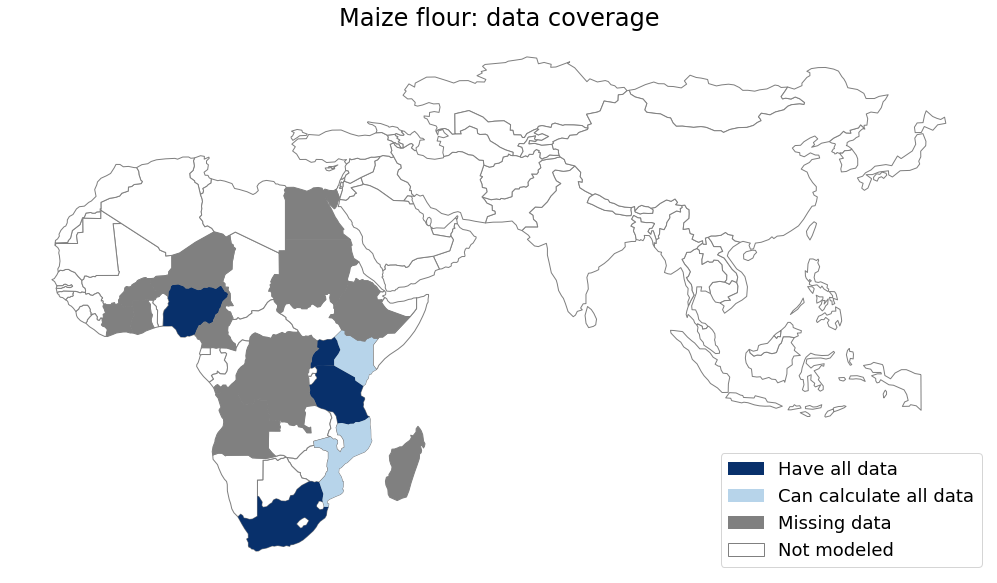

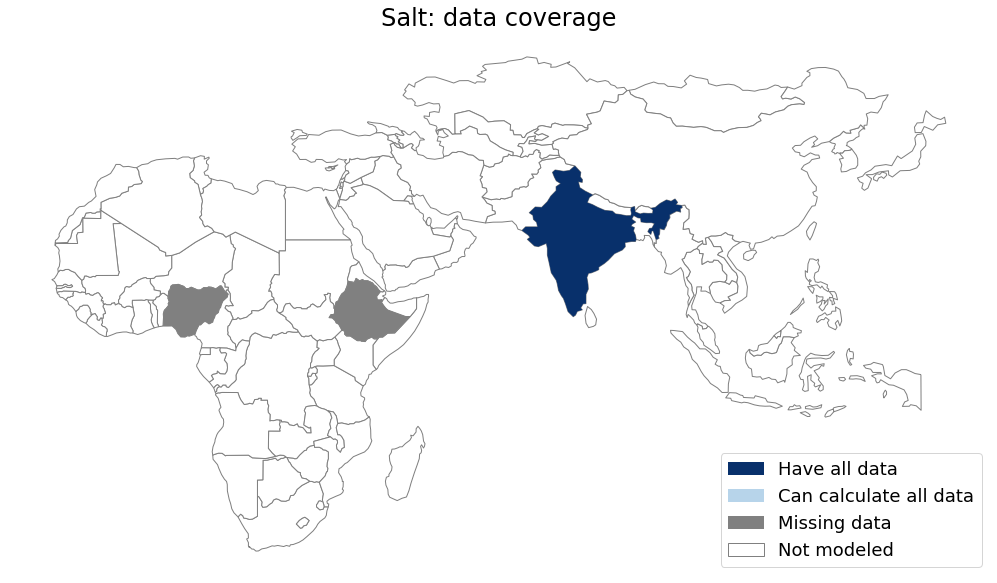

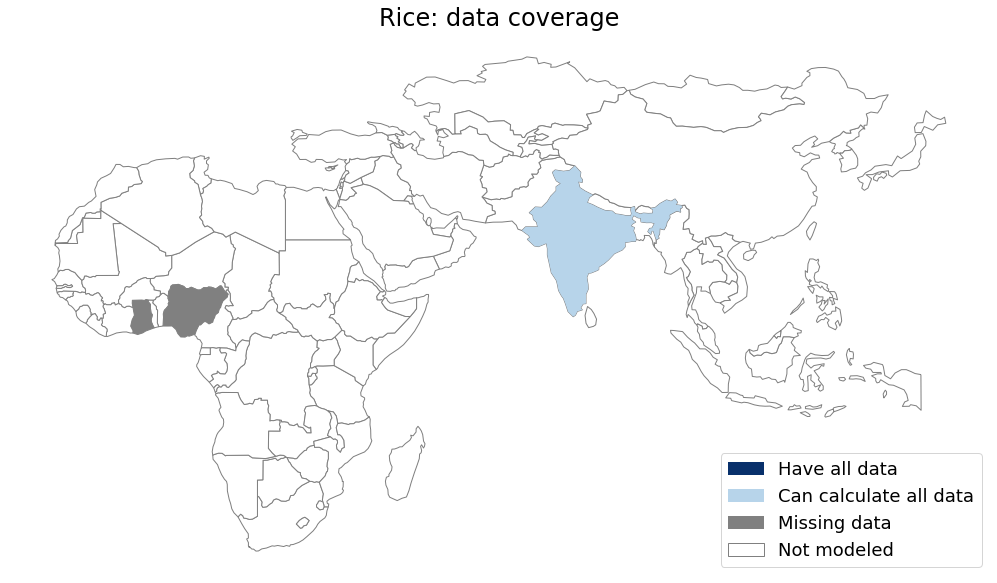

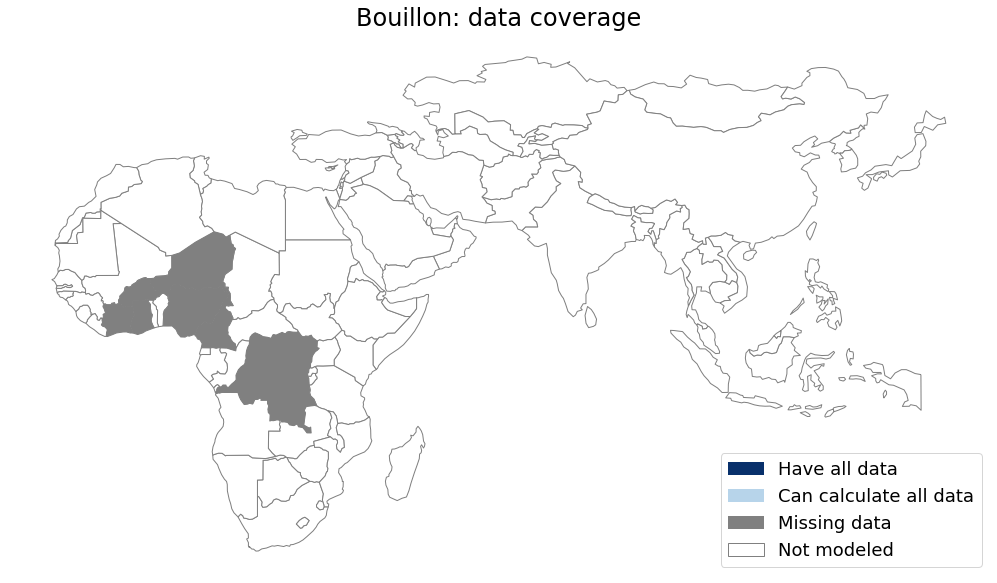

In [217]:
save_path = f'/ihme/homes/beatrixh/notebooks/viv_rsc/data_prep/outputs/plots/viv_model_input_data_coverage/data_completeness_nutrient_agnostic.pdf'
pdf = matplotlib.backends.backend_pdf.PdfPages(save_path)
for vehicle in vehicle_country_map.keys():
    fig = gen_plot_nutrient_agnostic(vehicle)
    pdf.savefig(fig)
pdf.close()